# Lab 2

In [2]:
import utils as ut
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from importlib import reload
import astropy.io.fits as fits
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.rcParams.update({'font.size': 13})

%matplotlib inline
pm = "\u00B1"  # plus-minus symbol for use in uncertainties

In [3]:
reload(ut)

<module 'utils' from '/Users/parkergeorge/UCSD/ASTR150/ASTRO150/utils.py'>

## 1. Read in Data

In [4]:
files = glob.glob('Lab2_data/*.csv')
# Swap Hydrogen to the front and Lamp to the back
files[0], files[5] = files[5], files[0]
files[2], files[5] = files[5], files[2]
print(files)

['Lab2_data/Hydrogen.csv', 'Lab2_data/Helium.csv', 'Lab2_data/Mercury.csv', 'Lab2_data/Neon.csv', 'Lab2_data/fluorescent.csv', 'Lab2_data/lamp.csv']


In [5]:
# 9 characters for lab2_data/ and -4 characters for .csv
name_slice = slice(10, -4)

In [6]:
all_data = ut.zeros(len(files))

for i, file in enumerate(files):
    # Read in csv file and skip the first 54 rows and the last line [End Of File]
    raw_data = pd.read_csv(file, engine='python',usecols=[0,1], skiprows=53, skipfooter=1)
    # Set the two columns of data to data type float
    raw_data['Pixel Number'] = raw_data['Pixel Number'].astype(float)
    raw_data['Measured Signal'] = raw_data['Measured Signal'].astype(float)

    all_data[i] = raw_data


all_data = np.array(all_data, dtype=np.float32)
print(all_data)

[[[ 3.2092020e+02  7.0856925e-04]
  [ 3.2102826e+02  6.1367161e-04]
  [ 3.2113632e+02  7.2754879e-04]
  ...
  [ 7.4311627e+02 -3.3530509e-04]
  [ 7.4323572e+02 -7.1489578e-04]
  [ 7.4335516e+02 -3.5997848e-03]]

 [[ 3.2092020e+02 -9.9711782e-05]
  [ 3.2102826e+02 -1.1633042e-03]
  [ 3.2113632e+02  6.9798250e-04]
  ...
  [ 7.4311627e+02 -1.5621514e-03]
  [ 7.4323572e+02 -1.6951003e-03]
  [ 7.4335516e+02 -1.8850275e-03]]

 [[ 3.2092020e+02 -6.6339772e-04]
  [ 3.2102826e+02  9.7055559e-04]
  [ 3.2113632e+02  1.1035518e-03]
  ...
  [ 7.4311627e+02 -5.1140203e-04]
  [ 7.4323572e+02 -2.7343384e-03]
  [ 7.4335516e+02 -1.4233760e-03]]

 [[ 3.2092020e+02 -1.2255252e-03]
  [ 3.2102826e+02  7.6951575e-04]
  [ 3.2113632e+02  8.8351814e-04]
  ...
  [ 7.4311627e+02 -2.3085473e-03]
  [ 7.4323572e+02 -9.7852002e-04]
  [ 7.4335516e+02 -2.5555524e-03]]

 [[ 3.2092020e+02 -2.4547029e-04]
  [ 3.2102826e+02  9.6604432e-05]
  [ 3.2113632e+02  7.0473726e-04]
  ...
  [ 7.4311627e+02 -3.3051386e-03]
  [ 7.4323

## 2. Plot all Data Files

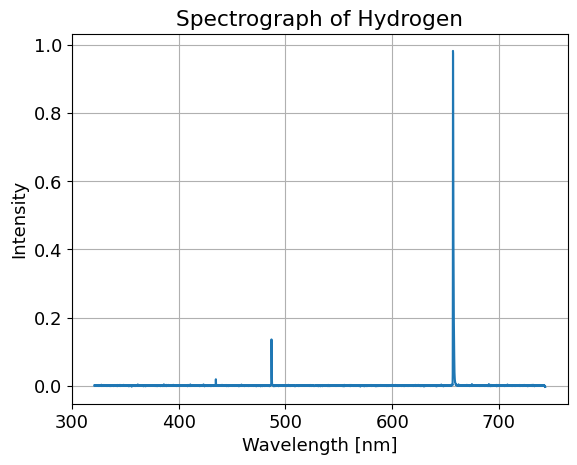

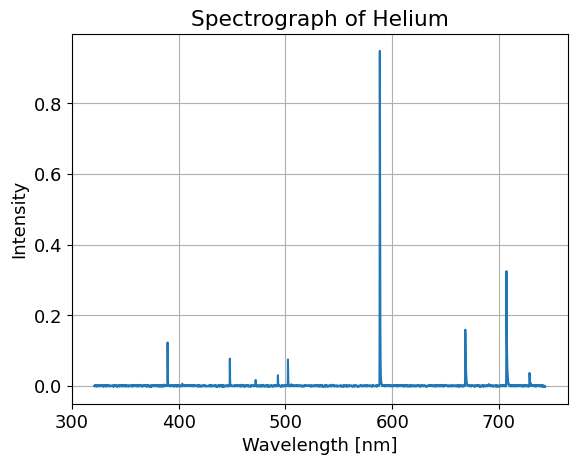

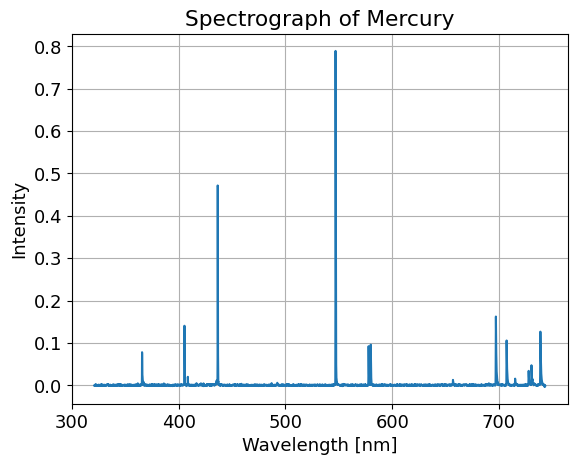

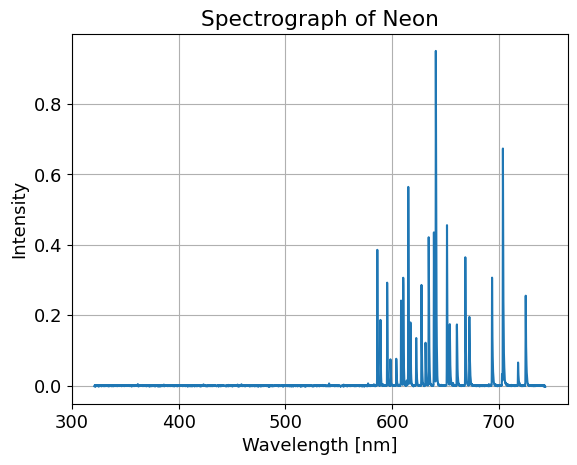

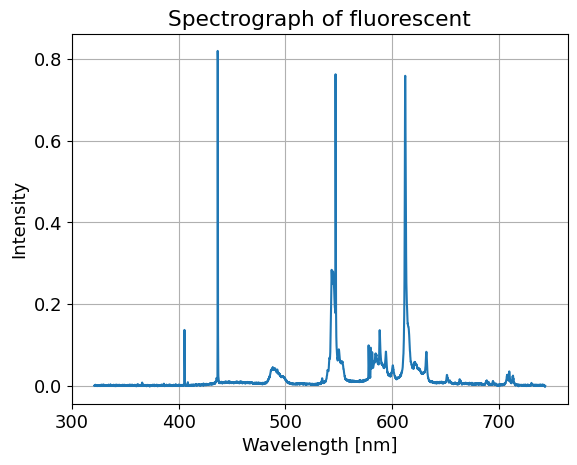

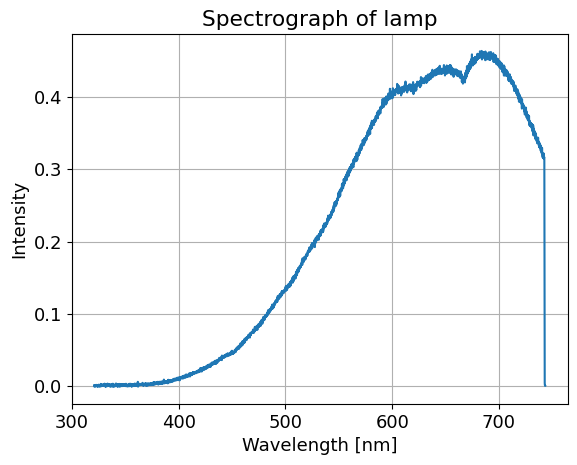

In [7]:
for i, data in enumerate(all_data):
    name = files[i][10:-4]
    x = data[:,0]
    y = data[:,1]
    plt.plot(x,y)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Intensity')
    plt.grid()
    plt.title(f'Spectrograph of {name}')
    plt.show()

## 3. Centroids and Pixel Numbers
$$
\left<x\right> = \frac{\sum x_i I_i}{\sum I_i}
$$

In [8]:
# exclude lamp dataset
n = all_data.shape[0] - 1
all_pixel_nums = ut.zeros(n, dtype=np.float32)
all_centroids = ut.zeros(n, dtype=np.float32)
all_centroid_variances = ut.zeros(n, dtype=np.float32)

# excluding lamp dataset
for i, data in enumerate(all_data[:-1]):
    (all_pixel_nums[i], all_centroids[i], all_centroid_variances[i]) = ut.get_centroids(data[:, 0], data[:, 1])

# sanity check with hydrogen, should be 3 centroid wavelengths at 435, 487 and 657 nm
print(all_pixel_nums[0])
print(all_centroids[0])
print(all_centroid_variances[0])

[1025 1479 2923]
[434.78128 486.98587 657.2641 ]
[4.9349481e-08 4.4849481e-02 2.8169736e-02]


## 4. Least Squares Fit
$$
y = mx+c
$$
$$
\begin{pmatrix}
\sum x_i^2 & \sum x_i \\[1mm]
\sum x_i & n
\end{pmatrix}
\begin{pmatrix}
m \\[1mm] c
\end{pmatrix}
= \begin{pmatrix}
\sum x_i y_i \\[1mm] \sum y_i
\end{pmatrix}
$$

In [9]:
slopes = ut.zeros(n, dtype=np.float32)
intercepts = ut.zeros(n, dtype=np.float32)

for i, pnum in enumerate(all_pixel_nums):
    slopes[i], intercepts[i] = ut.linear_least_squares(pnum, all_centroids[i])

print(slopes)
print(intercepts)

[np.float64(0.11738978926283394), np.float64(0.11744701313810757), np.float64(0.11707604280015294), np.float64(0.11915434442034467), np.float64(0.11724390244695715)]
[np.float64(313.9856212235336), np.float64(314.0682698334167), np.float64(315.62846854168265), np.float64(308.91466179491545), np.float64(315.5853252302527)]


### 4a. Error Propagation
$$
\sigma_m^2 = \frac{N\sigma^2}{N\sum x_i^2 - \left(\sum x_i\right)^2}
$$
$$
\sigma_c^2 = \frac{\sigma^2 \sum x_i^2}{N\sum x_i^2 - \left(\sum x_i\right)^2}
$$
$$
\sigma^2 = \frac{1}{N-2} \sum_i \left[y_i - (mx_i + c)\right]^2
$$

In [10]:
slope_errors = ut.zeros(n, dtype=np.float32)
intercept_errors = ut.zeros(n, dtype=np.float32)

for i, pnums in enumerate(all_pixel_nums):
    m = slopes[i]
    c = intercepts[i]
    centroids = all_centroids[i]
    N = len(centroids)

    # determine variance based on fit estimates
    tot = 0
    for j, xj in enumerate(pnums):
        tot += (centroids[j] - (m*xj + c)) ** 2
    variance = tot/(N-2)

    # calculate sums required for errors
    xsq_sum = ut.my_sum([xi**2 for xi in pnums])
    x_sum_sq = ut.my_sum([xi for xi in centroids]) ** 2

    # both uncertainties share a denominator, save computation
    denominator = N*xsq_sum - x_sum_sq

    # using formulas above
    slope_errors[i] = ((N*variance)/denominator)**.5
    intercept_errors[i] = ((variance*xsq_sum)/denominator)**.5

print(slope_errors)
print(intercept_errors)

[np.float64(0.0002393520108612582), np.float64(0.0001782603879320932), np.float64(0.0001314820476921579), np.float64(1.1326897430551008e-05), np.float64(0.00022612719959676865)]
[np.float64(0.47433576323123805), np.float64(0.4059531006729965), np.float64(0.3488566140962895), np.float64(0.031965287427926634), np.float64(0.5341023883408932)]


The slope error for Neon (index 3) is much lower than other data, most likely due to the large saturation of peaks in higher wavelengths. This result will cause some problems with weighing our measurements in the future.

### 4b. Weighted Means
$$
\sigma_{\bar{x}}^2 = \frac{1}{\sum \frac{1}{\sigma_i^2}}
$$
$$
\bar{x} = \sigma_{\bar{x}}^2 \sum \frac{x_i}{\sigma_i^2}
$$

In [11]:
slope_sig_sq_sum = ut.my_sum([1/(si**2) for si in slope_errors])
intercept_sig_sq_sum = ut.my_sum([1/(si**2) for si in intercept_errors])

slope_numerator = ut.my_sum([xi/(slope_errors[i]**2) for i, xi in enumerate(slopes)])
intercept_numerator = ut.my_sum([xi/(intercept_errors[i]**2) for i, xi in enumerate(intercepts)])

slope_error = 1 / slope_sig_sq_sum
slope = slope_numerator * slope_error

intercept_error = 1 / intercept_sig_sq_sum
intercept = intercept_numerator * intercept_error

print(f"m = {slope:.3g} {pm} {slope_error:.2g}")
print(f"c = {intercept:.3g} {pm} {intercept_error:.2g}")

m = 0.119 ± 1.3e-10
c = 309 ± 0.001


### 4c. Equally Weighted Means

Because of our extremely low slope error in Neon, we will go ahead and equally weigh everything and take the average for the best estimated result.

In [12]:
slope = ut.my_avg(slopes)
slope_error = ut.my_avg(slope_errors)
intercept = ut.my_avg(intercepts)
intercept_error = ut.my_avg(intercept_errors)
print(f"m = {slope:.4g} {pm} {slope_error:.2g}")
print(f"c = {intercept:.4g} {pm} {intercept_error:.2g}")

m = 0.1177 ± 0.00016
c = 313.6 ± 0.36


The wavelength calibration for our spectrometer is,
$$
\text{Wavelength} = m \cdot \left(\text{Pixel Number}\right) + c.
$$
Where,
$$
m = 0.1177 \pm 0.0002 \: \text{[nm/pixel]},
$$
and,
$$
c = 313.6 \pm 0.4 \: \text{[nm]}.
$$

### 4d. Wavelength vs. Centroid Plots
#### For Error Bars
$$
\begin{align}
y &= mx +c \\
\left<y\right> &= \sigma_m^2 x^2  + \sigma_c^2 \\
y_{err} &= \sqrt{\sigma_m^2 x^2  + \sigma_c^2}
\end{align}
$$

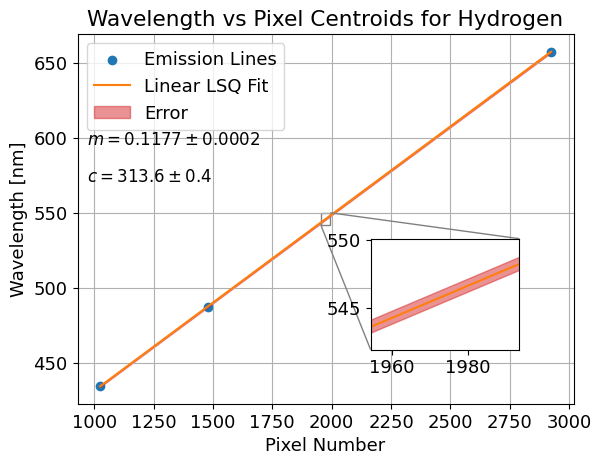

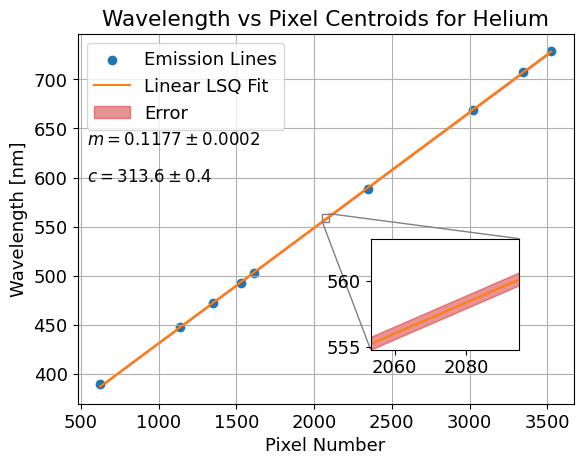

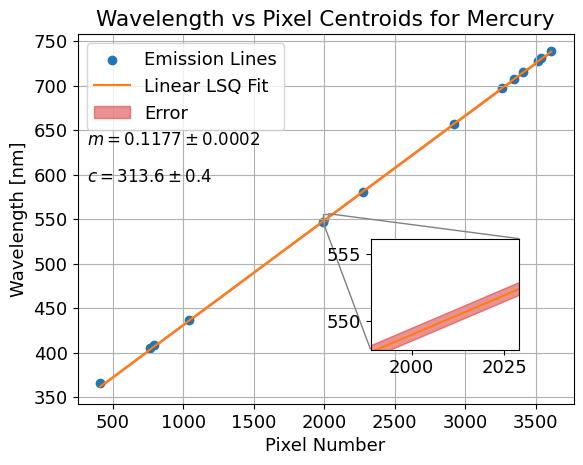

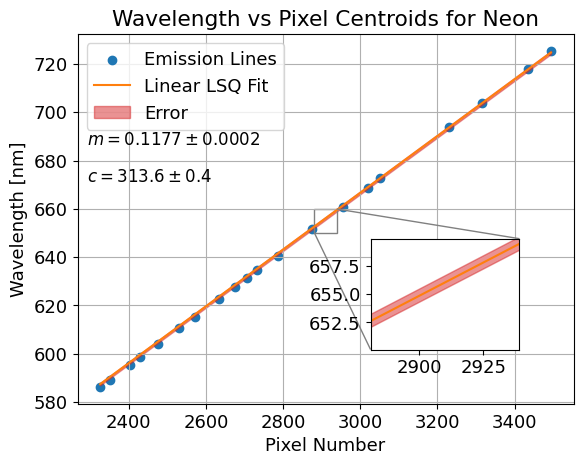

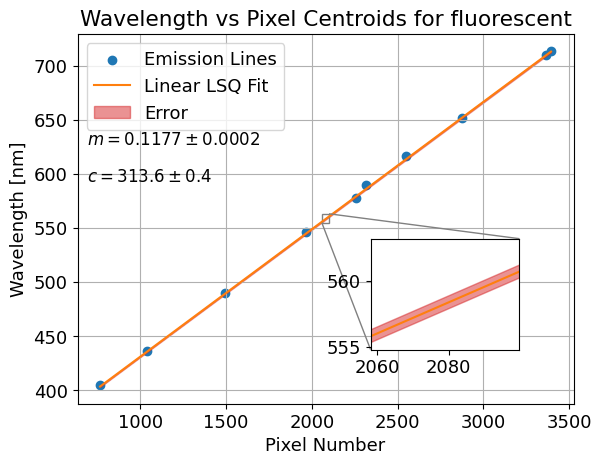

In [13]:
for idx in range(len(all_pixel_nums)):
    x = all_pixel_nums[idx]
    y = all_centroids[idx]
    y_regressed = slope*x + intercept
    yerr = (slope_error**2 * x**2 + intercept_error**2)**.5

    fig, ax = plt.subplots()
    ax.scatter(x, y, label='Emission Lines')
    ax.plot(x, y_regressed, c='tab:orange', label='Linear LSQ Fit')
    ax.fill_between(x, y_regressed - yerr, y_regressed + yerr, color='tab:red', alpha=0.5, label='Error')
    ax.set_xlabel("Pixel Number")
    ax.set_ylabel("Wavelength [nm]")
    ax.set_title(f"Wavelength vs Pixel Centroids for {files[idx][name_slice]}")
    ax.text(0.02, 0.7, r"$m=0.1177\pm0.0002$", fontsize=12, transform=ax.transAxes)
    ax.text(0.02, 0.6, r"$c=313.6\pm0.4$", fontsize=12, transform=ax.transAxes)
    ax.legend()
    ax.grid()

    # create zoomed in area by insetting an axis
    axins = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=3)

    # plot same line in inset area
    axins.plot(x, y_regressed, c='tab:orange')
    axins.fill_between(x, y_regressed - yerr, y_regressed + yerr, color='tab:red', alpha=0.5)

    # define the zoom region.
    # For example, zoom in on the mid-region within a certain percentage of main frame
    midx = (x.max() + x.min())//2
    width_percent = 0.01
    x_start = midx * (1 - width_percent)
    x_end = midx * (1 + width_percent)

    midy = (y.max() + y.min())//2
    height_percent = .75 * width_percent    # based on default aspect ratio of 6.4:4.8
    y_start = midy * (1 - height_percent)
    y_end = midy * (1 + height_percent)

    axins.set_xlim(x_start, x_end)
    axins.set_ylim(y_start, y_end)

    # connecting lines for visualization
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")


    plt.show()

## 5. KAST Data
### 5a. Read Data

In [32]:
frames = glob.glob('data-2013-10-26-shane-public/b1[0-6][0-9].fits')
ut.ascend_str(frames, (-7, -5))
arc = frames[0]
arc_frame = ut.get_data(arc)
bias = frames[1:11]
bias_frames = ut.get_data(bias)
flats_slit4 = frames[11:21]
slit4 = ut.get_data(flats_slit4)
flats_slit2 = frames[21:51]
slit2 = ut.get_data(flats_slit2)

arc, bias, flats_slit4, flats_slit2

('data-2013-10-26-shane-public/b100.fits',
 ['data-2013-10-26-shane-public/b101.fits',
  'data-2013-10-26-shane-public/b102.fits',
  'data-2013-10-26-shane-public/b103.fits',
  'data-2013-10-26-shane-public/b104.fits',
  'data-2013-10-26-shane-public/b105.fits',
  'data-2013-10-26-shane-public/b106.fits',
  'data-2013-10-26-shane-public/b107.fits',
  'data-2013-10-26-shane-public/b108.fits',
  'data-2013-10-26-shane-public/b109.fits',
  'data-2013-10-26-shane-public/b110.fits'],
 ['data-2013-10-26-shane-public/b111.fits',
  'data-2013-10-26-shane-public/b112.fits',
  'data-2013-10-26-shane-public/b113.fits',
  'data-2013-10-26-shane-public/b114.fits',
  'data-2013-10-26-shane-public/b115.fits',
  'data-2013-10-26-shane-public/b116.fits',
  'data-2013-10-26-shane-public/b117.fits',
  'data-2013-10-26-shane-public/b118.fits',
  'data-2013-10-26-shane-public/b119.fits',
  'data-2013-10-26-shane-public/b120.fits'],
 ['data-2013-10-26-shane-public/b121.fits',
  'data-2013-10-26-shane-public

### 5b. Test Data

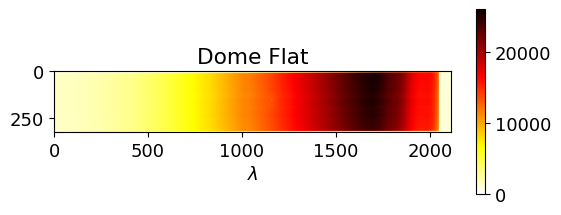

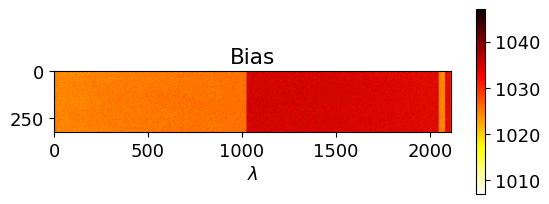

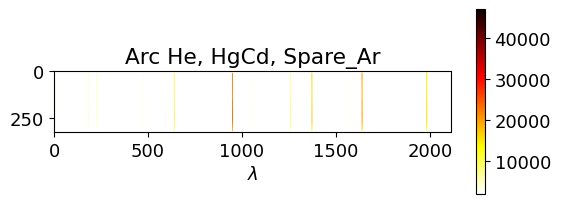

In [15]:
# Quick imshow frame test
test_dome = slit2[5]
test_bias = bias_frames[5]
test_arc = arc_frame

plt.imshow(test_dome, cmap='hot_r', vmin=0)
plt.title('Dome Flat')
plt.xlabel(r'$\lambda$')
plt.colorbar(shrink=.5)
plt.show()

plt.imshow(test_bias, cmap='hot_r')
plt.title('Bias')
plt.xlabel(r'$\lambda$')
plt.colorbar(shrink=.5)
plt.show()

plt.imshow(test_arc, cmap='hot_r', vmin=2000)
plt.title('Arc He, HgCd, Spare_Ar')
plt.xlabel(r'$\lambda$')
plt.colorbar(shrink=.5)
plt.show()

In [16]:
# quick data display check
with fits.open(flats_slit4[0]) as hdu:
    hdr = hdu[0].header
    display(hdr)

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 2112 / NUMBER OF COLUMNS                              
NAXIS2  =                  325 / NUMBER OF ROWS                                 
CRVAL1U =                    0 / COLUMN ORIGIN                                  
CRVAL2U =                 1255 / ROW ORIGIN                                     
CDELT1U =                    1 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -1 / ROW CHANGE PER PIXEL                           
OBSNUM  =                  111 / OBSERVATION NUMBER                             
IDNUM   =                    5 / IMAGE ID                                       
UGEOM   =                    6 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

### 5c. Master Bias

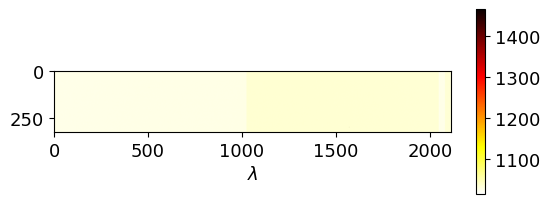

In [17]:
master_bias = ut.my_bias(bias)
plt.imshow(master_bias, cmap='hot_r')
plt.xlabel(r'$\lambda$')
plt.colorbar(shrink=.5)
plt.show()

### 5d. Bias Subtraction

(325, 2112)
(30, 325, 2112)
(10, 325, 2112)


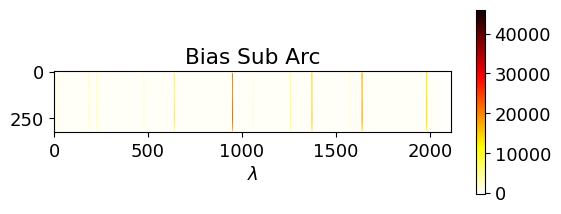

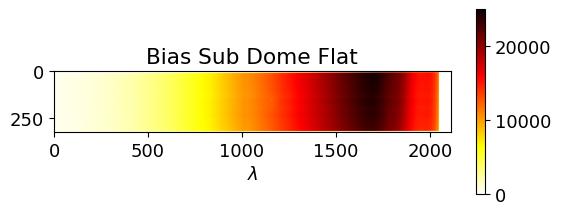

In [18]:
arc_clean = ut.bias_sub(arc_frame, master_bias, num_arrays=1)
print(np.shape(arc_clean))
slit2_clean = ut.bias_sub(slit2, master_bias)
print(np.shape(slit2_clean))
ut.set_negatives_to_zero_nd(slit2_clean)
slit4_clean = ut.bias_sub(slit4, master_bias)
print(np.shape(slit4_clean))
ut.set_negatives_to_zero_nd(slit4_clean)

plt.imshow(arc_clean, cmap='hot_r')
plt.title('Bias Sub Arc')
plt.xlabel(r'$\lambda$')
plt.colorbar(shrink=.5)
plt.show()

plt.imshow(slit2_clean[5], cmap='hot_r')
plt.title('Bias Sub Dome Flat')
plt.xlabel(r'$\lambda$')
plt.colorbar(shrink=.5)
plt.show()

### 5e. Normalize Dome Flats

[[3.78184718e-03 3.99159755e-03 4.19493388e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.86515339e-03 4.00378208e-03 4.05455969e-03 ... 3.43499999e-05
  0.00000000e+00 0.00000000e+00]
 [4.10765728e-03 4.38611938e-03 3.91428313e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.79054849e-02 4.85507290e-02 4.91280104e-02 ... 5.47612334e-04
  5.53621133e-04 5.85900851e-04]
 [4.69654159e-02 4.79295931e-02 4.75870380e-02 ... 3.20116501e-04
  5.37866715e-04 6.30563686e-04]
 [3.89534679e-02 3.84251254e-02 3.98047830e-02 ... 3.90708585e-04
  6.09045736e-04 3.10268583e-04]]
(325, 2112)


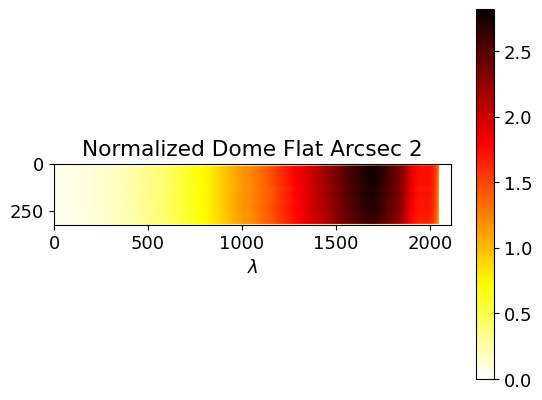

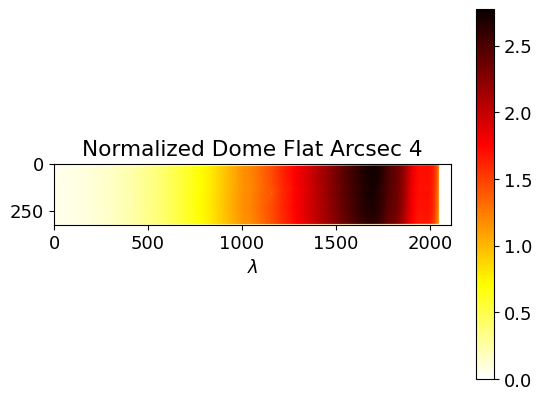

In [19]:
norm_slit2 = ut.normalize_flats(slit2_clean)
print(norm_slit2)
norm_slit4 = ut.normalize_flats(slit4_clean)
print(np.shape(norm_slit4))

plt.imshow(norm_slit2, cmap='hot_r', vmin=0)
plt.title('Normalized Dome Flat Arcsec 2')
plt.xlabel(r'$\lambda$')
plt.colorbar()
plt.show()

plt.imshow(norm_slit4, cmap='hot_r', vmin=0)
plt.title('Normalized Dome Flat Arcsec 4')
plt.xlabel(r'$\lambda$')
plt.colorbar()
plt.show()

### 5f. Choose two Science frames to Reduce

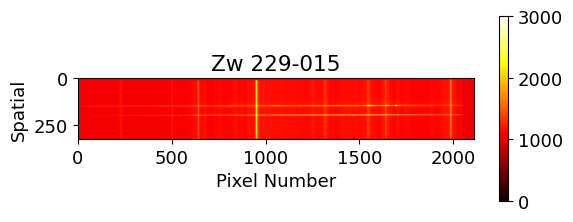

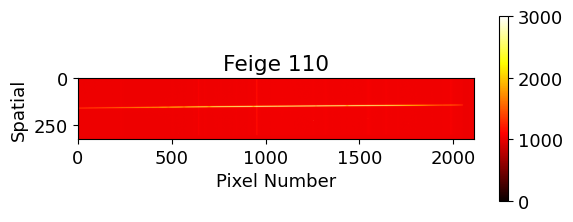

('data-2013-10-26-shane-public/b151.fits',
 'data-2013-10-26-shane-public/b160.fits',
 numpy.ndarray)

In [20]:
science1 = frames[-10]
science2 = frames[-1]

Zw = ut.get_data(science1)
feige = ut.get_data(science2)

plt.imshow(Zw, cmap='hot', vmin=0, vmax=3000)
plt.title('Zw 229-015')
plt.xlabel('Pixel Number')
plt.ylabel('Spatial')
plt.colorbar(shrink=.5)
plt.show()

plt.imshow(feige, cmap='hot', vmin=0, vmax=3000)
plt.title('Feige 110')
plt.xlabel('Pixel Number')
plt.ylabel('Spatial')
plt.colorbar(shrink=.5)
plt.show()

science1, science2, type(Zw)

In [21]:
# Check for slit position
with fits.open(science1) as hdu: # 4.0 Arcsec
    hdr = hdu[0].header
    display(hdr)

with fits.open(science2) as hdu: # 2.0 Arcsec
    hdr = hdu[0].header
    display(hdr)

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 2112 / NUMBER OF COLUMNS                              
NAXIS2  =                  325 / NUMBER OF ROWS                                 
CRVAL1U =                    0 / COLUMN ORIGIN                                  
CRVAL2U =                 1255 / ROW ORIGIN                                     
CDELT1U =                    1 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -1 / ROW CHANGE PER PIXEL                           
OBSNUM  =                  151 / OBSERVATION NUMBER                             
IDNUM   =                    5 / IMAGE ID                                       
UGEOM   =                    6 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 2112 / NUMBER OF COLUMNS                              
NAXIS2  =                  325 / NUMBER OF ROWS                                 
CRVAL1U =                    0 / COLUMN ORIGIN                                  
CRVAL2U =                 1255 / ROW ORIGIN                                     
CDELT1U =                    1 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -1 / ROW CHANGE PER PIXEL                           
OBSNUM  =                  160 / OBSERVATION NUMBER                             
IDNUM   =                    6 / IMAGE ID                                       
UGEOM   =                    6 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

### 5g. Reduce Science Frames

(325, 2112)
(325, 2112)


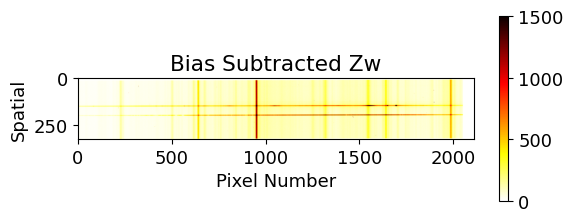

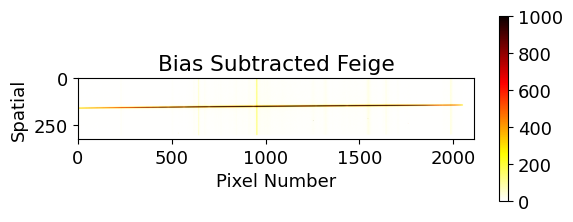

In [22]:
# Bias Subtract the Science Frames

Zw_clean = ut.bias_sub(Zw, master_bias, num_arrays=1)
ut.set_negatives_to_zero_nd(Zw_clean)
print(np.shape(Zw_clean))
feige_clean = ut.bias_sub(feige, master_bias, num_arrays=1)
ut.set_negatives_to_zero_nd(feige_clean)
print(np.shape(feige_clean))

plt.imshow(Zw_clean, cmap='hot_r', vmin=0, vmax=1500)
plt.title('Bias Subtracted Zw')
plt.xlabel('Pixel Number')
plt.ylabel('Spatial')
plt.colorbar(shrink=.5)
plt.show()

plt.imshow(feige_clean, cmap='hot_r', vmin=0, vmax=1000)
plt.title('Bias Subtracted Feige')
plt.xlabel('Pixel Number')
plt.ylabel('Spatial')
plt.colorbar(shrink=.5)
plt.show()


(325, 2112)
(325, 2112)


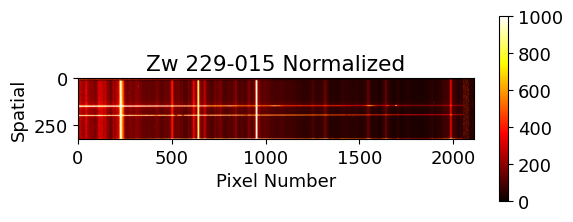

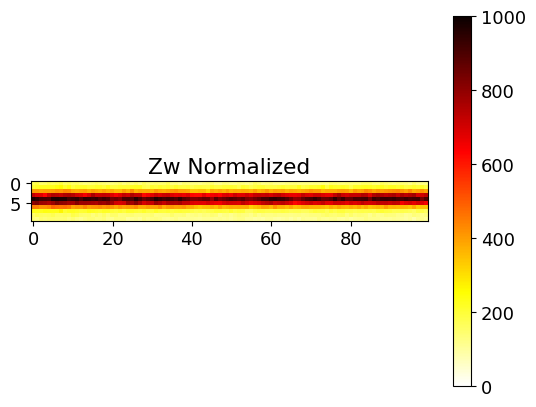

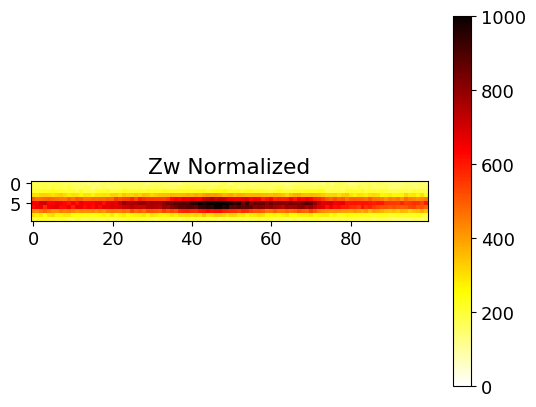

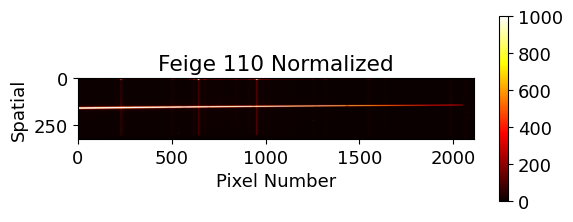

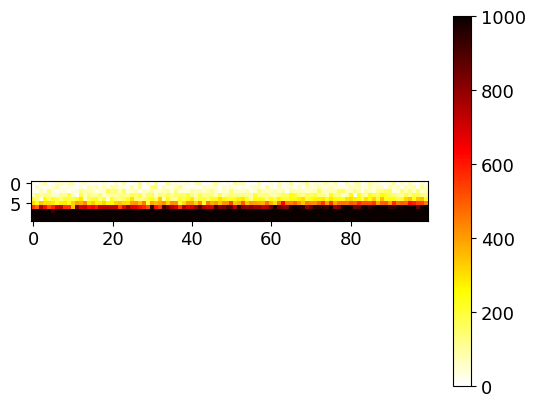

In [23]:
# Dome Flat Normalization of the Science Frames
Zw_norm = ut.norm(Zw_clean, norm_slit4)
print(np.shape(Zw_norm))

feige_norm = ut.norm(feige_clean, norm_slit2)
print(np.shape(feige_norm))

plt.imshow(Zw_norm, cmap='hot', vmin=0, vmax=1000)
plt.title('Zw 229-015 Normalized')
plt.xlabel('Pixel Number')
plt.ylabel('Spatial')
plt.colorbar(shrink=.5)
plt.show()

plt.imshow(Zw_norm[195:205,1000:1100], cmap='hot_r', vmin=0, vmax=1000)
plt.title('Zw Normalized')
plt.colorbar()
plt.show()

plt.imshow(Zw_norm[145:155,1000:1100], cmap='hot_r', vmin=0, vmax=1000)
plt.title('Zw Normalized')
plt.colorbar()
plt.show()

plt.imshow(feige_norm, cmap='hot', vmin=0, vmax=1000)
plt.title('Feige 110 Normalized')
plt.xlabel('Pixel Number')
plt.ylabel('Spatial')
plt.colorbar(shrink=.5)
plt.show()

plt.imshow(feige_norm[151:161,100:200], cmap='hot_r', vmin=0, vmax=1000)
plt.colorbar()
plt.show()

### 5h. Plot of Arc Lamp

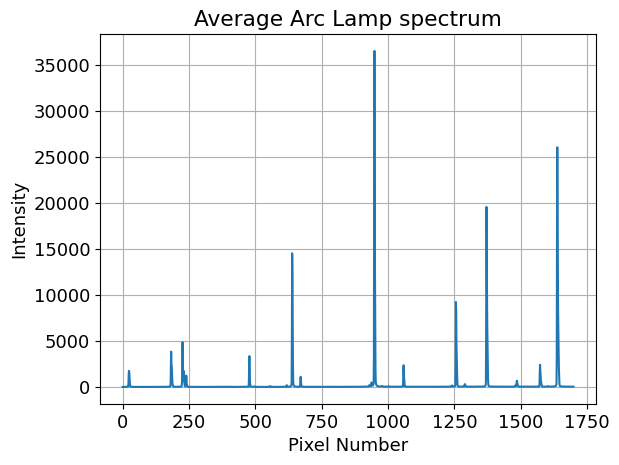

In [24]:

arc_spec = np.mean(arc_clean, axis=0)[0:1700]

arc_pixels = np.arange(len(arc_spec))
plt.plot(arc_pixels, arc_spec)
plt.title('Average Arc Lamp spectrum')
plt.xlabel('Pixel Number')
plt.ylabel('Intensity')
plt.grid()
plt.show()

### 5i. Centroid and Method of Least Squares of Arc Lamp

In [25]:
# Set known wavelengths
known_wavelengths = np.array([4046.56, 4358.33, 4678.16, 4799.92, 5085.82])
known_wavelengths/=10
# Calcualte the pixel number indicies of the centroids
(arc_pixel_nums, arc_centroids, arc_centroid_variances) = ut.get_centroids(arc_pixels, arc_spec, threshold=5000)
print(arc_centroids)
# Calcualte the slop and y intercept of the best fit
arc_slope, arc_intercept = ut.linear_least_squares(arc_centroids, known_wavelengths)
print(arc_slope, arc_intercept)

[ 639.49726103  949.43836264 1256.47400143 1371.87838335 1638.81472782]
0.1039671986683679 337.60728067900254


In [26]:
# Calculate the errors in the slope and y intercept
m = arc_slope
c = arc_intercept
centroids = known_wavelengths
N = len(centroids)

# determine variance based on fit estimates
tot = 0
for j, xj in enumerate(arc_pixel_nums):
    tot += (centroids[j] - (m*xj + c)) ** 2
variance = tot/(N-2)

# calculate sums required for errors
xsq_sum = ut.my_sum([xi**2 for xi in arc_pixel_nums])
x_sum_sq = ut.my_sum([xi for xi in centroids]) ** 2

# both uncertainties share a denominator, save computation
denominator = N*xsq_sum - x_sum_sq

# using formulas above
slope_error = ((N*variance)/denominator)**.5
intercept_error = ((variance*xsq_sum)/denominator)**.5
print(slope_error, intercept_error)

0.0002491551347857312 0.3041151077402221


In [27]:
print(f"m = {arc_slope:.3g} {pm} {slope_error:.2g}")
print(f"c = {arc_intercept:.3g} {pm} {intercept_error:.2g}")

m = 0.104 ± 0.00025
c = 338 ± 0.3


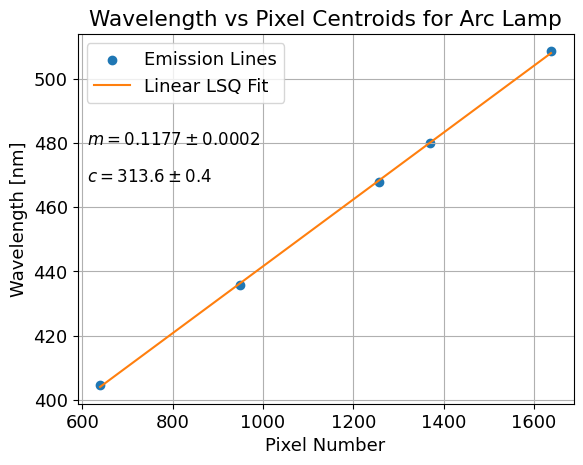

In [28]:
## Plot Arc Lamp Wavelength Solution

x = arc_pixel_nums
y = known_wavelengths
y_regressed = arc_slope*x + arc_intercept
yerr = (slope_error**2 * x**2 + intercept_error**2)**.5

fig, ax = plt.subplots()
ax.scatter(x, y, label='Emission Lines')
ax.plot(x, y_regressed, c='tab:orange', label='Linear LSQ Fit')
ax.set_xlabel("Pixel Number")
ax.set_ylabel("Wavelength [nm]")
ax.set_title(f"Wavelength vs Pixel Centroids for Arc Lamp")
ax.text(0.02, 0.7, r"$m=0.1177\pm0.0002$", fontsize=12, transform=ax.transAxes)
ax.text(0.02, 0.6, r"$c=313.6\pm0.4$", fontsize=12, transform=ax.transAxes)
ax.legend()
ax.grid()

# create zoomed in area by insetting an axis
# axins = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=3)

# plot same line in inset area
# axins.plot(x, y_regressed, c='tab:orange')
# axins.fill_between(x, y_regressed - yerr, y_regressed + yerr, color='tab:green', alpha=0.5)

# define the zoom region.
# For example, zoom in on the mid-region within a certain percentage of main frame
# midx = (x.max() + x.min())//2
# width_percent = 0.01
# x_start = midx * (1 - width_percent)
# x_end = midx * (1 + width_percent)

# midy = (y.max() + y.min())//2
# height_percent = .75 * width_percent    # based on default aspect ratio of 6.4:4.8
# y_start = midy * (1 - height_percent)
# y_end = midy * (1 + height_percent)
#
# axins.set_xlim(x_start, x_end)
# axins.set_ylim(y_start, y_end)

# connecting lines for visualization
# mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")


plt.show()

### 5j. Apply wavelength solution to science frames

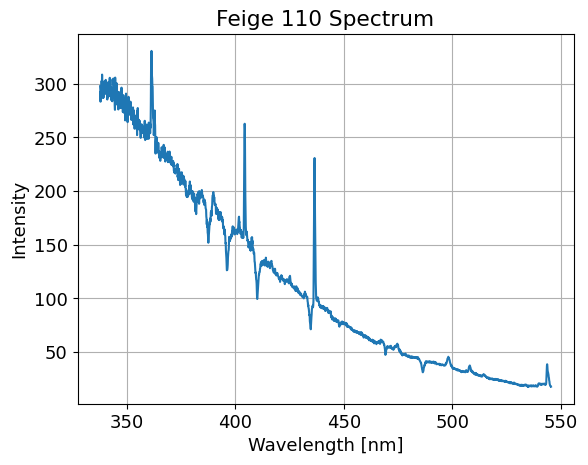

In [29]:
feige_plot = np.mean(feige_norm[100:200, 0:2000], axis=0)

feige_pixel_nums = np.arange(len(feige_plot)) * arc_slope
plt.plot(feige_pixel_nums + arc_intercept, feige_plot)
plt.title('Feige 110 Spectrum')
plt.ylabel('Intensity')
plt.xlabel('Wavelength [nm]')
plt.grid()
plt.show()

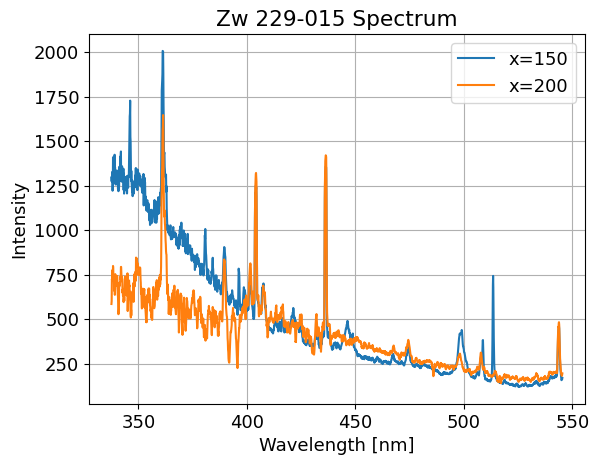

In [30]:
Zw_plot = np.mean(Zw_norm[145:155, 0:2000], axis=0)
Zw_plot1 = np.mean(Zw_norm[195:205, 0:2000], axis=0)

Zw_pix_nums = np.arange(len(Zw_plot)) * arc_slope
Zw1_pix_nums = np.arange(len(Zw_plot1)) * arc_slope

plt.plot(Zw_pix_nums + arc_intercept, Zw_plot, label='x=150')
plt.plot(Zw1_pix_nums + arc_intercept, Zw_plot1, label='x=200')
plt.title('Zw 229-015 Spectrum')
plt.ylabel('Intensity')
plt.xlabel('Wavelength [nm]')
plt.legend()
plt.grid()
plt.show()

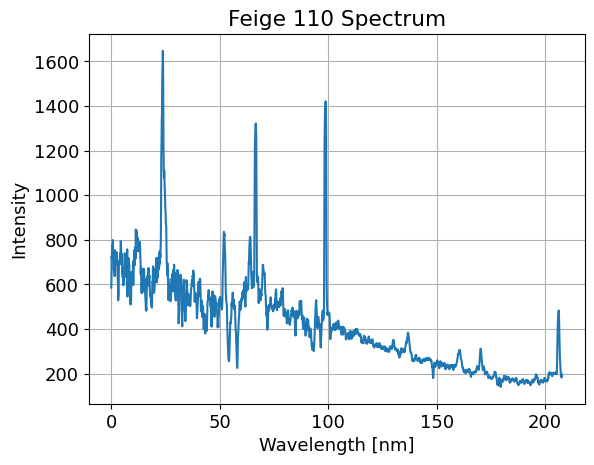

In [31]:
Zw_plot1 = np.mean(Zw_norm[195:205, 0:2000], axis=0)

Zw1_pix_nums = np.arange(len(Zw_plot1)) * arc_slope
plt.plot(Zw1_pix_nums, Zw_plot1)
plt.title('Feige 110 Spectrum')
plt.ylabel('Intensity')
plt.xlabel('Wavelength [nm]')
plt.grid()
plt.show()